# Transformer Encoder 기반 예측



# ✅ 🔹 Transformer Encoder 기반 테슬라 주가 예측 코드

[*********************100%***********************]  1 of 1 completed


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 2.8911 - val_loss: 0.1593
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1973 - val_loss: 0.0098
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1162 - val_loss: 0.0406
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0790 - val_loss: 0.0097
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0548 - val_loss: 0.0071
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0666 - val_loss: 0.0281
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0544 - val_loss: 0.0117
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0593 - val_loss: 0.0074
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0645 - val_loss: 0.0098
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0481 - val_loss: 0.0085
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0512 - val_loss: 0.0087
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.

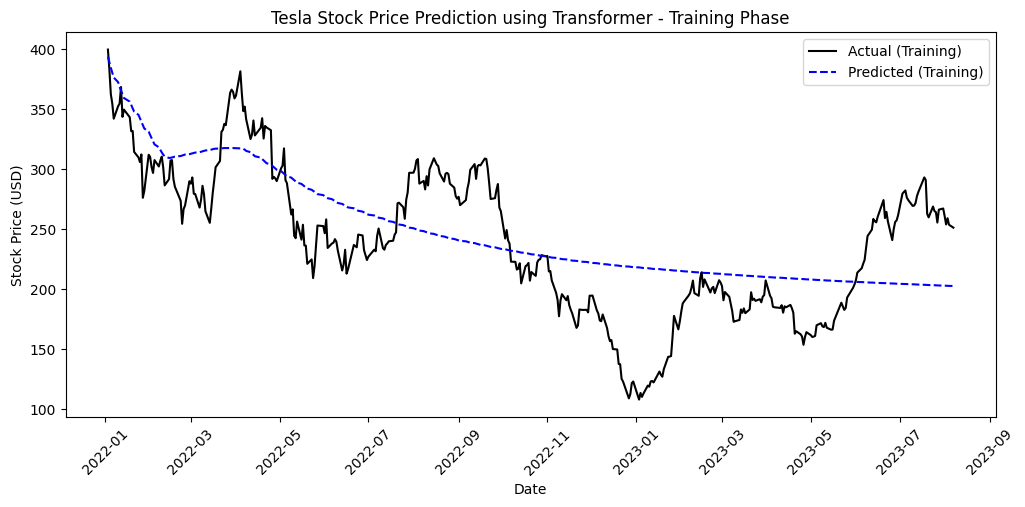

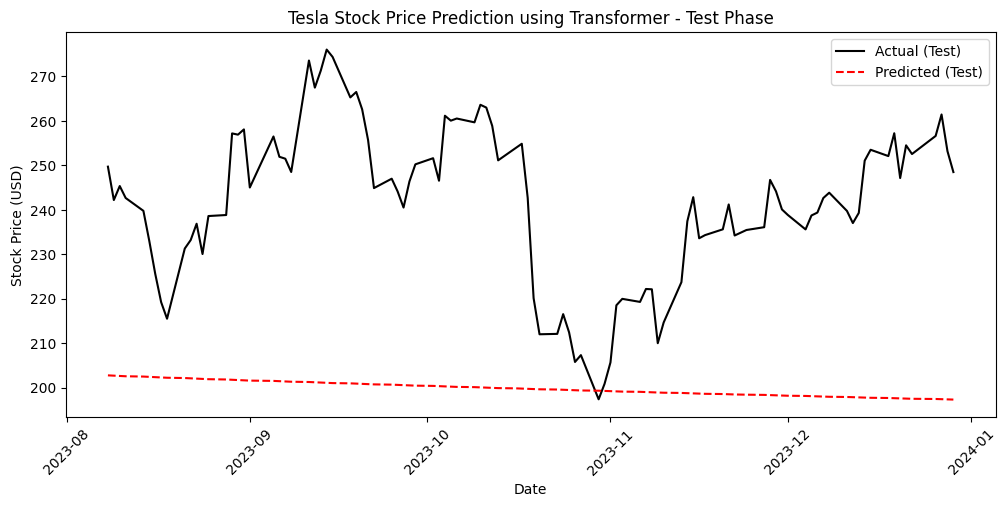

In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 📌 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드
def get_tesla_stock():
    df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
    df = df.reset_index()
    df["Day"] = np.arange(len(df))  # 날짜를 숫자로 변환 (단순한 X 값으로 사용)
    return df, df[['Day']].values, df['Close'].values  # 날짜(X)와 종가(Y) 반환

# 📌 2️⃣ Transformer Encoder Layer 정의
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 📌 3️⃣ Transformer 기반 모델 생성 (슬라이딩 윈도우 없음)
def build_transformer_model(input_shape, embed_dim=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(embed_dim)(inputs)  # Linear Projection (Embedding)

    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)(x)

    x = Dense(1)(x[:, -1, :])  # 마지막 타임스텝 사용하여 예측
    model = Model(inputs, x)
    return model

# 📌 4️⃣ 데이터 전처리 및 학습
def main():
    # ✅ 1️⃣ 데이터 로드 및 전처리
    df, X, y = get_tesla_stock()

    # 데이터 정규화 (MinMaxScaler)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # ✅ 2️⃣ 데이터 분할 (80% 학습, 20% 테스트)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

    # 입력 데이터 차원 변경 (Transformer에 맞게 reshape)
    X_train = X_train.reshape(X_train.shape[0], 1, 1)  # (batch, time step, feature)
    X_test = X_test.reshape(X_test.shape[0], 1, 1)

    # ✅ 3️⃣ 모델 생성 및 컴파일
    model = build_transformer_model(input_shape=(1, 1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # ✅ 4️⃣ 모델 학습
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # ✅ 5️⃣ 예측 수행
    y_train_pred = model.predict(X_train, batch_size=32)
    y_test_pred = model.predict(X_test, batch_size=32)

    # ✅ 6️⃣ 예측 데이터 역정규화
    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))

    # 📌 7️⃣ 성능 평가
    train_mse = mean_squared_error(y_train_actual, y_train_pred_actual)
    test_mse = mean_squared_error(y_test_actual, y_test_pred_actual)
    train_r2 = r2_score(y_train_actual, y_train_pred_actual)
    test_r2 = r2_score(y_test_actual, y_test_pred_actual)

    print(f"📌 Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"📌 Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

    # ✅ 8️⃣ 결과 시각화

    # 📌 9️⃣ 훈련 데이터 예측 vs 실제값
    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"].iloc[:len(X_train)], y_train_actual, label="Actual (Training)", color="black")
    plt.plot(df["Date"].iloc[:len(X_train)], y_train_pred_actual, label="Predicted (Training)", color="blue", linestyle="--")
    plt.title("Tesla Stock Price Prediction using Transformer - Training Phase")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    # 📌 🔟 테스트 데이터 예측 vs 실제값
    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"].iloc[len(X_train):], y_test_actual, label="Actual (Test)", color="black")
    plt.plot(df["Date"].iloc[len(X_train):], y_test_pred_actual, label="Predicted (Test)", color="red", linestyle="--")
    plt.title("Tesla Stock Price Prediction using Transformer - Test Phase")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


# ✅ 🚀 Sliding Window 적용된 Transformer 기반 테슬라 주가 예측 코드:

[*********************100%***********************]  1 of 1 completed


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 2.4117 - val_loss: 0.3777
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.3081 - val_loss: 0.0139
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1375 - val_loss: 0.0253
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0825 - val_loss: 0.0038
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0719 - val_loss: 0.0027
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0597 - val_loss: 0.0061
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0582 - val_loss: 0.0042
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0416 - val_loss: 0.0021
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.0461 - val_loss: 0.0017
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0421 - val_loss: 7.4827e-04
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0332 - val_loss: 0.0035
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step 

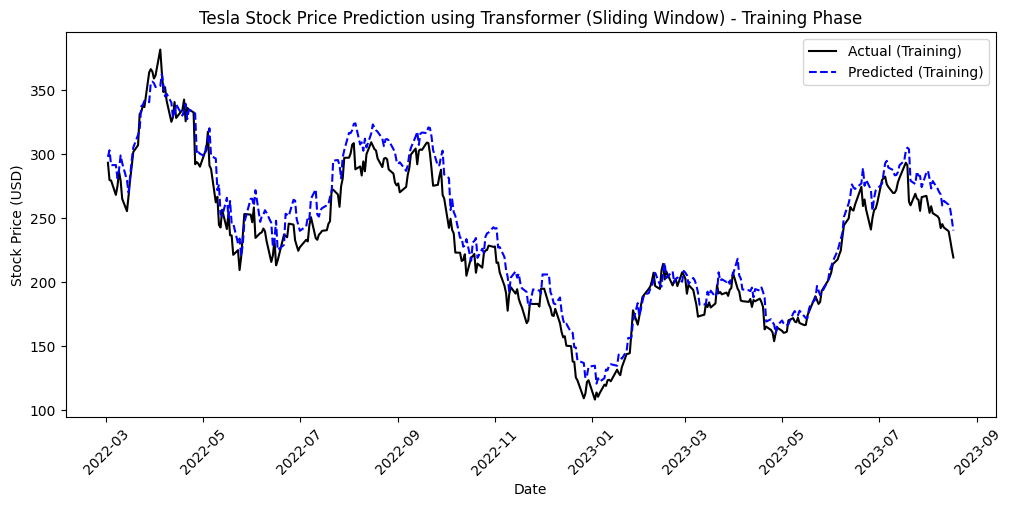

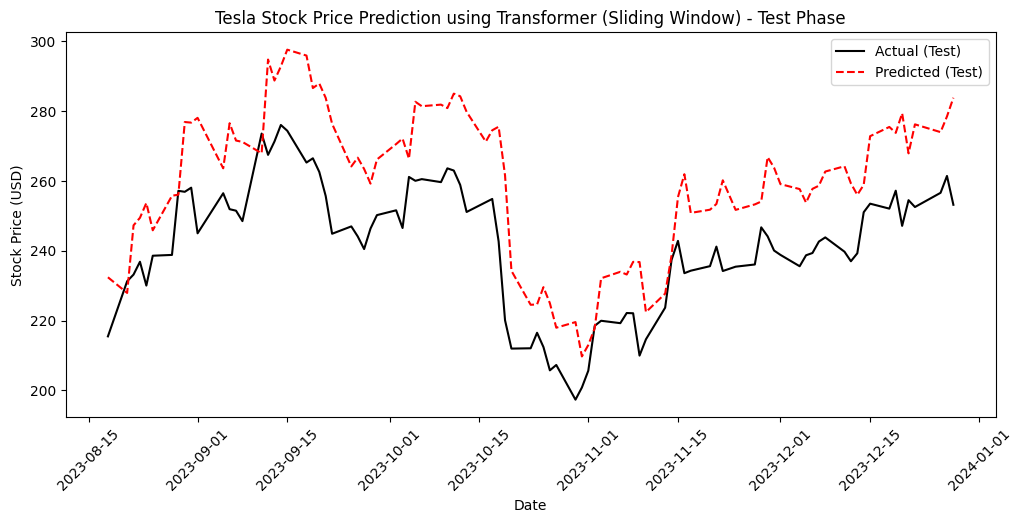

In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 📌 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드
def get_tesla_stock():
    df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
    df = df.reset_index()
    close_prices = df['Close'].values  # 종가 데이터 사용
    return df, close_prices

# 📌 2️⃣ Sliding Window 데이터셋 생성
def create_sliding_window_data(data, window_size, output_size):
    X, y = [], []
    for i in range(len(data) - window_size - output_size):
        X.append(data[i:i + window_size])  # 과거 window_size만큼의 데이터
        y.append(data[i + window_size: i + window_size + output_size])  # 미래 output_size일 예측
    return np.array(X), np.array(y)

# 📌 3️⃣ Transformer Encoder Layer 정의
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 📌 4️⃣ Transformer 기반 모델 생성
def build_transformer_model(input_shape, output_size, embed_dim=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(embed_dim)(inputs)  # Linear Projection (Embedding)

    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)(x)

    x = Dense(output_size)(x[:, -1, :])  # 마지막 타임스텝 사용하여 미래 output_size일 예측
    model = Model(inputs, x)
    return model

# 📌 5️⃣ 데이터 전처리 및 학습
def main():
    # ✅ 1️⃣ 데이터 로드 및 전처리
    df, data = get_tesla_stock()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    # ✅ 2️⃣ Sliding Window 데이터셋 생성
    window_size = 40  # 입력 시퀀스 길이
    output_size = 1   # 🔄 미래 1일 예측 (단일 스텝)
    X, y = create_sliding_window_data(data_scaled, window_size, output_size)

    # ✅ 3️⃣ 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 입력 데이터 차원 변경 (Transformer에 맞게 reshape)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # ✅ 4️⃣ 모델 생성 및 컴파일
    model = build_transformer_model(input_shape=(window_size, 1), output_size=output_size)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # ✅ 5️⃣ 모델 학습
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # ✅ 6️⃣ 예측 수행
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # ✅ 7️⃣ 예측 데이터 역정규화
    y_train_actual = scaler.inverse_transform(y_train)
    y_train_pred_actual = scaler.inverse_transform(y_train_pred)

    y_test_actual = scaler.inverse_transform(y_test)
    y_test_pred_actual = scaler.inverse_transform(y_test_pred)

    # 📌 1️⃣1️⃣ 성능 평가
    train_mse = mean_squared_error(y_train_actual, y_train_pred_actual)
    test_mse = mean_squared_error(y_test_actual, y_test_pred_actual)
    train_r2 = r2_score(y_train_actual, y_train_pred_actual)
    test_r2 = r2_score(y_test_actual, y_test_pred_actual)

    print(f"📌 Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"📌 Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

    # ✅ 8️⃣ 결과 시각화

    # 📌 9️⃣ 훈련 데이터 예측 vs 실제값
    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"].iloc[window_size:window_size + len(y_train_actual)], y_train_actual, label="Actual (Training)", color="black")
    plt.plot(df["Date"].iloc[window_size:window_size + len(y_train_actual)], y_train_pred_actual, label="Predicted (Training)", color="blue", linestyle="--")
    plt.title("Tesla Stock Price Prediction using Transformer (Sliding Window) - Training Phase")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    # 📌 🔟 테스트 데이터 예측 vs 실제값
    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"].iloc[window_size + len(y_train_actual):window_size + len(y_train_actual) + len(y_test_actual)], y_test_actual, label="Actual (Test)", color="black")
    plt.plot(df["Date"].iloc[window_size + len(y_train_actual):window_size + len(y_train_actual) + len(y_test_actual)], y_test_pred_actual, label="Predicted (Test)", color="red", linestyle="--")
    plt.title("Tesla Stock Price Prediction using Transformer (Sliding Window) - Test Phase")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


# ✅ 🚀 하이퍼파라미터 튜닝이 적용된 transformer encoder 기반 테슬라 주가 예측 코드

In [30]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.2 MB/s eta 0:00:00


[I 2025-02-08 11:10:19,103] A new study created in memory with name: no-name-4e9daba6-8045-4250-880c-208cfd8c555b
[*********************100%***********************]  1 of 1 completed


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


[I 2025-02-08 11:11:00,410] Trial 0 finished with value: 0.008245013802981807 and parameters: {'embed_dim': 128, 'num_heads': 2, 'ff_dim': 128, 'num_layers': 1, 'dropout': 0.19787770043079395, 'learning_rate': 0.004541627631823942, 'batch_size': 32}. Best is trial 0 with value: 0.008245013802981807.
[*********************100%***********************]  1 of 1 completed


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


[I 2025-02-08 11:13:46,564] Trial 1 finished with value: 0.0053245133327337185 and parameters: {'embed_dim': 128, 'num_heads': 4, 'ff_dim': 256, 'num_layers': 2, 'dropout': 0.23741564680451874, 'learning_rate': 0.0008560607238562199, 'batch_size': 64}. Best is trial 1 with value: 0.0053245133327337185.
[*********************100%***********************]  1 of 1 completed


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step


[I 2025-02-08 11:14:37,066] Trial 2 finished with value: 0.00385285174855548 and parameters: {'embed_dim': 32, 'num_heads': 4, 'ff_dim': 128, 'num_layers': 3, 'dropout': 0.14799719567173428, 'learning_rate': 0.0099813987476554, 'batch_size': 64}. Best is trial 2 with value: 0.00385285174855548.
[*********************100%***********************]  1 of 1 completed


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2025-02-08 11:15:12,459] Trial 3 finished with value: 0.0035506101601926747 and parameters: {'embed_dim': 64, 'num_heads': 4, 'ff_dim': 256, 'num_layers': 1, 'dropout': 0.22985293804582882, 'learning_rate': 0.0007928019963496589, 'batch_size': 64}. Best is trial 3 with value: 0.0035506101601926747.
[*********************100%***********************]  1 of 1 completed


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


[I 2025-02-08 11:15:46,141] Trial 4 finished with value: 0.0029466262040511253 and parameters: {'embed_dim': 32, 'num_heads': 2, 'ff_dim': 64, 'num_layers': 2, 'dropout': 0.20219338739246917, 'learning_rate': 0.0048362278063707005, 'batch_size': 16}. Best is trial 4 with value: 0.0029466262040511253.
[*********************100%***********************]  1 of 1 completed

✅ 최적의 하이퍼파라미터: {'embed_dim': 32, 'num_heads': 2, 'ff_dim': 64, 'num_layers': 2, 'dropout': 0.20219338739246917, 'learning_rate': 0.0048362278063707005, 'batch_size': 16}


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 2.4505 - val_loss: 0.0848
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2059 - val_loss: 0.0042
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0942 - val_loss: 0.0087
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0887 - val_loss: 0.0103
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0816 - val_loss: 0.0156
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0605 - val_loss: 0.0023
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0478 - val_loss: 0.0013
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0336 - val_loss: 9.0788e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0230 - val_loss: 0.0012
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0191 - val_loss: 0.0025
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0160 - val_loss: 0.0026
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss:

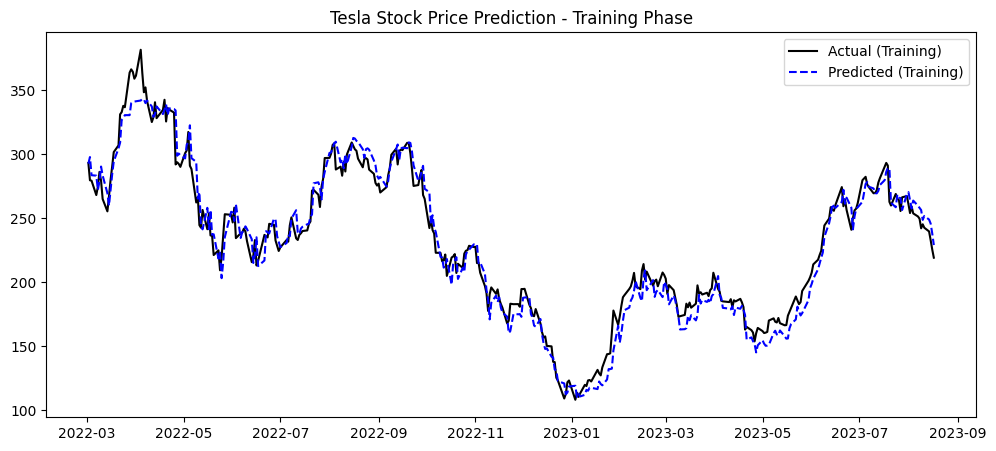

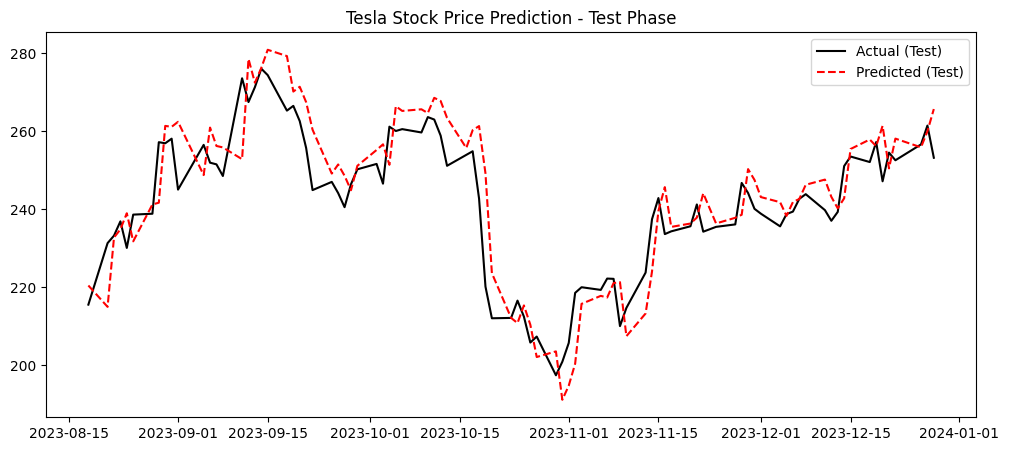

In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna  # 📌 하이퍼파라미터 튜닝용 라이브러리

# 📌 하이퍼파라미터 최적화 여부 설정
optimize_hyperparameters = True  # True이면 Optuna 실행, False이면 미리 정의된 값 사용

# ✅ 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드
def get_tesla_stock():
    df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")
    df = df.reset_index()
    close_prices = df['Close'].values  # 종가 데이터 사용
    return df, close_prices

# ✅ 2️⃣ Sliding Window 데이터셋 생성
def create_sliding_window_data(data, window_size, output_size):
    X, y = [], []
    for i in range(len(data) - window_size - output_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size: i + window_size + output_size])
    return np.array(X), np.array(y)

# ✅ 3️⃣ Transformer Encoder Layer 정의
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ✅ 4️⃣ Transformer 기반 모델 생성
def build_transformer_model(input_shape, output_size, embed_dim, num_heads, ff_dim, num_layers, dropout):
    inputs = Input(shape=input_shape)
    x = Dense(embed_dim)(inputs)

    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)(x)

    x = Dense(output_size)(x[:, -1, :])
    model = Model(inputs, x)
    return model

# ✅ 5️⃣ Optuna를 사용한 하이퍼파라미터 튜닝 함수
def objective(trial):
    embed_dim = trial.suggest_categorical("embed_dim", [32, 64, 128])
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    df, data = get_tesla_stock()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    window_size = 40
    output_size = 1
    X, y = create_sliding_window_data(data_scaled, window_size, output_size)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = build_transformer_model((window_size, 1), output_size, embed_dim, num_heads, ff_dim, num_layers, dropout)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    y_test_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_test_pred)

# ✅ 6️⃣ 실험 실행
def run_experiment():
    if optimize_hyperparameters:
        # ✅ Optuna 실행
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=5)  # 5번 실험 (테스트를 위해 줄임)
        best_params = study.best_params
        print("✅ 최적의 하이퍼파라미터:", best_params)
    else:
        # ✅ 사전 설정된 최적 하이퍼파라미터 사용
        best_params = {
            'embed_dim': 128,
            'num_heads': 2,
            'ff_dim': 64,
            'num_layers': 3,
            'dropout': 0.22847888473055616,
            'learning_rate': 0.00043936237753954243,
            'batch_size': 16
        }
        print("✅ 사전 설정된 최적 하이퍼파라미터 사용:", best_params)

    df, data = get_tesla_stock()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    window_size = 40
    output_size = 1
    X, y = create_sliding_window_data(data_scaled, window_size, output_size)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # ✅ `learning_rate`와 `batch_size`는 `model.compile()` 및 `model.fit()`에서 직접 사용
    model = build_transformer_model(
        (window_size, 1), output_size,
        best_params["embed_dim"], best_params["num_heads"], best_params["ff_dim"],
        best_params["num_layers"], best_params["dropout"]
    )
    model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss="mse")
    model.fit(X_train, y_train, epochs=50, batch_size=best_params["batch_size"], validation_data=(X_test, y_test))


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_actual = scaler.inverse_transform(y_train)
    y_test_actual = scaler.inverse_transform(y_test)
    y_train_pred_actual = scaler.inverse_transform(y_train_pred)
    y_test_pred_actual = scaler.inverse_transform(y_test_pred)

    # ✅ 성능 평가
    train_mse = mean_squared_error(y_train_actual, y_train_pred_actual)
    test_mse = mean_squared_error(y_test_actual, y_test_pred_actual)
    train_r2 = r2_score(y_train_actual, y_train_pred_actual)
    test_r2 = r2_score(y_test_actual, y_test_pred_actual)

    print(f"📌 Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"📌 Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

    # ✅ 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"].iloc[window_size:window_size + len(y_train_actual)], y_train_actual, label="Actual (Training)", color="black")
    plt.plot(df["Date"].iloc[window_size:window_size + len(y_train_actual)], y_train_pred_actual, label="Predicted (Training)", linestyle="--", color="blue")
    plt.title("Tesla Stock Price Prediction - Training Phase")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    test_date_range = df["Date"].iloc[window_size + len(y_train_actual): window_size + len(y_train_actual) + len(y_test_actual)]
    plt.plot(test_date_range, y_test_actual, label="Actual (Test)", color="black")
    plt.plot(test_date_range, y_test_pred_actual, label="Predicted (Test)", linestyle="--", color="red")
    plt.title("Tesla Stock Price Prediction - Test Phase")
    plt.legend()
    plt.show()

if __name__ == '__main__':
    run_experiment()
